In [107]:
%load_ext autoreload
%autoreload 2

import os
import json
from functools import reduce
import numpy as np

from conf import conf
from models.tensorflow.conf import tf_conf

import tensorflow as tf
tfk = tf.keras
import tensorflow_probability as tfp
tfd = tfp.distributions
import tensorflow_datasets as tfds
K=tfk.backend

import plotly.graph_objs as go
import plotly.express as px
from plotly.offline import iplot

from models.tensorflow.rnade import Rnade
from models.tensorflow.rnade_deep import RnadeDeep
from models.tensorflow.maf import MAF
from models.tensorflow.mdn import MDN
from models.tensorflow.monde import MONDE
from models.tensorflow.monde_ar import MondeAR
from data import registry
from models.tensorflow.compute import get_device
from utils import elapsed_timer
import utils as nl_utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Experiment setting

In [108]:
n_data=10000
batch_size=128
max_epochs=100000
os.environ['CUDA_VISIBLE_DEVICES']="0"
tf_conf.per_process_gpu_memory = {'0':1024,'1':1024}
conf.visible_device_list = [0]
device = get_device(tf_conf, conf)

# Load the data

In [109]:
conf.dir = '{ROOT}/density/inv_sin_normal'
data_loader = registry.inv_sin_normal()

loaded data: inv_sin_noise-data.memmap


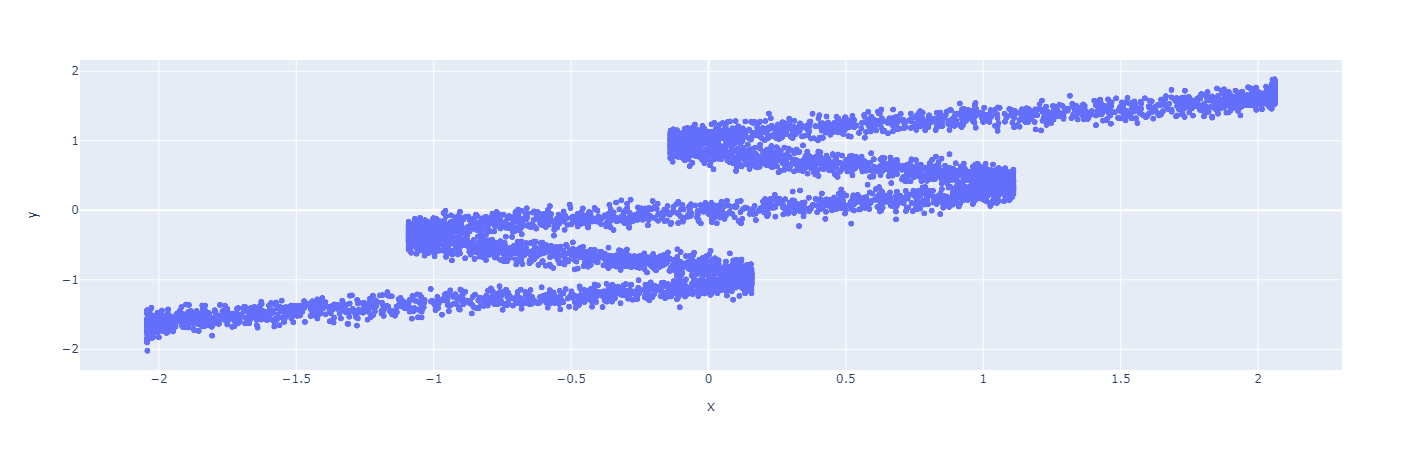

In [110]:
px.scatter(x=data_loader.train_data[:,0],y=data_loader.train_data[:,1])

In [111]:
train_dataset = tf.data.Dataset.from_tensor_slices(
        ((data_loader.train_y, data_loader.train_x), np.zeros((len(data_loader.train_y), 0), dtype=np.float32)))
train_dataset = train_dataset.repeat(None)
train_dataset = train_dataset.shuffle(buffer_size=len(data_loader.train_y))
train_dataset = train_dataset.prefetch(3 * batch_size)
train_dataset = train_dataset.batch(batch_size)

val_dataset = tf.data.Dataset.from_tensor_slices(
        ((data_loader.validation_y, data_loader.validation_x), np.zeros((len(data_loader.validation_y), 0), dtype=np.float32)))
val_dataset = val_dataset.repeat(1)
val_dataset = val_dataset.prefetch(len(data_loader.validation_y))
val_dataset = val_dataset.batch(len(data_loader.validation_y))

# Choose model to train

In [116]:
K.clear_session()
with tf.device(device):
#     model = Rnade(k_mix = 10, hidden_units=128, component_distribution="normal")
#     model = Rnade(k_mix = 10, hidden_units=128, component_distribution="laplace")
#     model = RnadeDeep(k_mix = 10, arch=[64,64], component_distribution="normal") # 6,366
#     model = RnadeDeep(k_mix = 10, arch=[64,64], component_distribution="laplace") # 6,366
#     model = MAF(num_bijectors=5, hidden_units=[32,32], covariate_hidden_units=[32,32], batch_norm=False) #5,188
#     model = MDN(arch=[64,64], num_mixtures=10) # 6,238
#     model = MONDE(cov_type="const_cov", arch_hxy=[128,128,128], arch_x_transform=[], arch_cov_transform=None, hxy_x_size=64, covariance_learning_rate=None)
    model = MondeAR(arch=[32,32,32], transform = 'sigm', x_transform_size=16) # 2,241
    model.build([[None,1],[None,1]])
model.summary()

Model: "monde_ar"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
monde_ar_layer (MondeARLayer multiple                  2241      
Total params: 2,241
Trainable params: 2,241
Non-trainable params: 0
_________________________________________________________________


# Train the model

training took 262.71691642299993 seconds


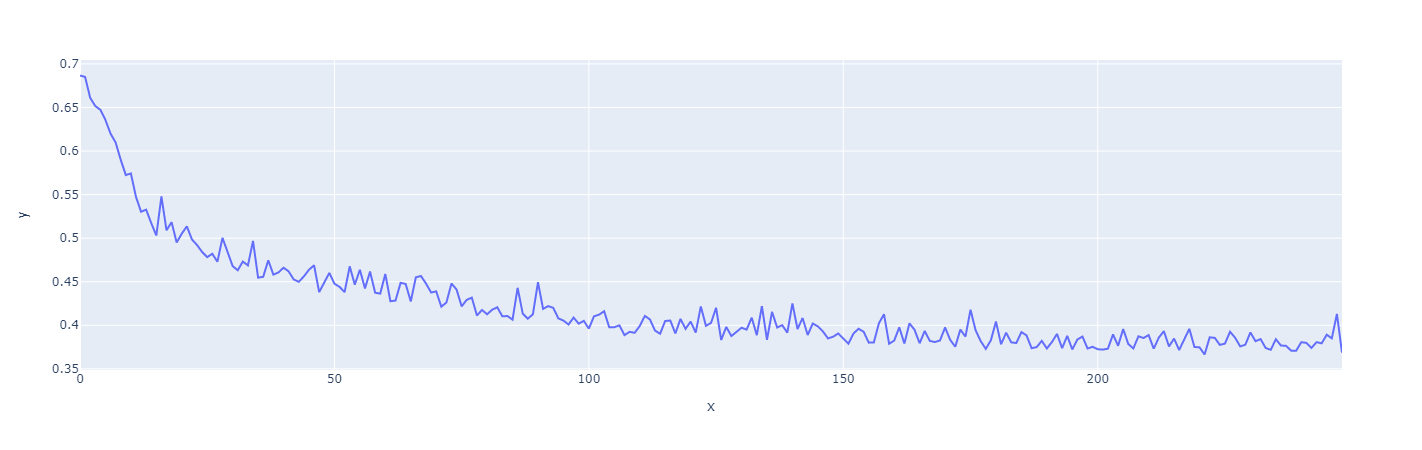

In [113]:
def loss_fn(_, log_prob):
    return -tf.reduce_mean(log_prob)

model.compile(optimizer=tfk.optimizers.Adam(learning_rate=1e-3), loss=loss_fn)

os.makedirs('test', exist_ok=True)
model.save_to_json('test/{}_best_model.json'.format(model.model_name))

callbacks = []
callbacks.append(tfk.callbacks.TerminateOnNaN())
callbacks.append(tfk.callbacks.ModelCheckpoint('test/{}_best_model.h5'.format(model.model_name), 
                                               monitor='val_loss', mode='min', verbose=0, save_best_only=True, save_weights_only=True))
callbacks.append(tfk.callbacks.History())
callbacks.append(tfk.callbacks.EarlyStopping(monitor='loss', patience=30))

steps_per_epoch = int(np.ceil(len(data_loader.train_y) / batch_size))
with elapsed_timer("training"):
    history = model.fit(x=train_dataset, validation_data=val_dataset,verbose=0, epochs=max_epochs, steps_per_epoch=steps_per_epoch, callbacks=callbacks)

px.line(x=history.epoch,y=history.history['val_loss'])

# Load the best model

In [117]:
with tf.device(device):
    model = nl_utils.load_model_and_params('test/{}_best_model'.format(model.model_name))

# Show what model has learnt

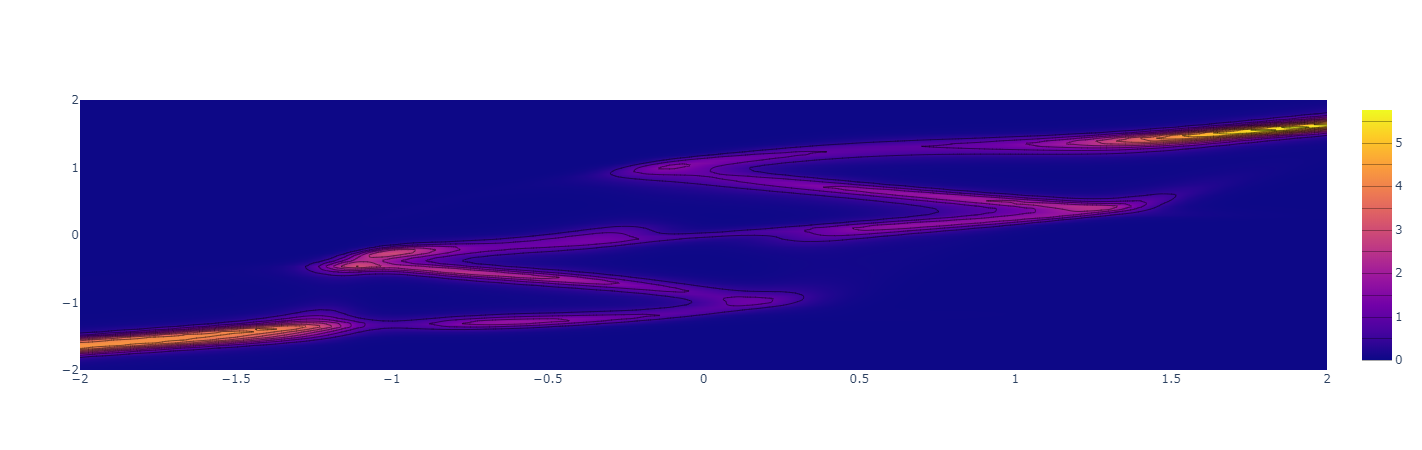

In [118]:
y_maxes = np.array([2,2],np.float32)
y_mins = np.array([-2,-2],np.float32)
y1_grid=np.linspace(y_mins[0],y_maxes[0],100, dtype=np.float32)
y2_grid=np.linspace(y_mins[1],y_maxes[1],100, dtype=np.float32)
yy1,yy2 = np.meshgrid(y1_grid,y2_grid)

prob = model.prob(tf.convert_to_tensor(yy2.reshape([-1,1])),tf.convert_to_tensor(yy1.reshape([-1,1])), training=False).numpy()

fig = go.Figure(data =
    go.Contour(
        z=prob.reshape(y1_grid.size,y2_grid.size),
        x=y1_grid,
        y=y2_grid,        
        contours_coloring='heatmap'
    ))
fig.show()